In [1]:
import sys
import theano
import os
import time
import numpy as np
import theano.tensor as T
from theano import function
from theano.tensor.shared_randomstreams import RandomStreams
import lasagne
from lasagne.layers import InputLayer, Conv2DLayer, Pool2DLayer, DropoutLayer, \
Deconv2DLayer, DenseLayer, Upscale2DLayer, ReshapeLayer, \
get_output, get_all_params, get_all_layers,  count_params
from lasagne.nonlinearities import rectify as relu
from lasagne.nonlinearities import linear
from lasagne.objectives import squared_error
from lasagne.updates import nesterov_momentum
import matplotlib
import matplotlib.pyplot as plt
import h5py
import copy
if __name__ == "__main__":
    sys.path.insert(0,'..')
    from common import _day_iterator
else:
    from ..common import _day_iterator

%matplotlib inline

import time
#import util.preprocessing
from sklearn.manifold import TSNE

#enable importing of notebooks
from nbfinder import NotebookFinder
sys.meta_path.append(NotebookFinder())



import numpy as np

In [3]:
from nolearn.lasagne import NeuralNet

In [4]:


def build_network(nkwargs):
    
    opt_kwargs = {k:nkwargs[k] for k in ['learning_rate','momentum']}

    

    network, hid_layer = build_denoising_convae(input_var, nkwargs)
    
    #get outputs
    prediction = get_output(network, deterministic=False)
    hid_layer_output = get_output(hid_layer, deterministic=True)
    
    #make losses
    loss = squared_error(prediction, target_var).mean()
    test_prediction = get_output(network, deterministic=True)
    test_loss = squared_error(test_prediction,target_var).mean()
    test_acc = test_loss 
    
    #set up updates
    params = get_all_params(network, trainable=True)
    updates = nesterov_momentum(loss, params, **opt_kwargs)

    
    #make fns
    train_fn = function([input_var, target_var], loss, updates=updates)
    val_fn = function([input_var, target_var], [test_loss, test_acc])
    pred_fn = function([input_var], test_prediction)
    hlayer_fn = function([input_var], hid_layer_output )

    return train_fn, val_fn, pred_fn, hlayer_fn, network

def build_denoising_convae(input_var, nkwargs):
    
    corrupted_input = corrupt(input_var, nkwargs)
    
    hid_layer = build_encoder(corrupted_input, nkwargs)
    

    network = build_decoder(hid_layer, nkwargs)

    print_layers(network)
    
    return network, hid_layer

def build_encoder(input_var, nkwargs):
    
    conv_kwargs = {k: nkwargs[k] for k in ['num_filters', 'W', 'nonlinearity']}
    dense_kwargs = {k: nkwargs[k] for k in ['num_units','W', 'nonlinearity']}
    
    net = InputLayer(shape=nkwargs['input_shape'], input_var=input_var)
    net = Conv2DLayer(net, filter_size=(2,2), pad=(2,0), stride=(1,2), **conv_kwargs)
    net = Conv2DLayer(net, filter_size=(2,2),pad=(1,0),stride=2, **conv_kwargs)
    net = DropoutLayer(net, p=nkwargs['p'])
    net = DenseLayer(net, **dense_kwargs)
    
    return net

In [5]:
def build_decoder(hid_layer, nkwargs):
    
    # the last shape before the fully connected layers
    last_conv_shape = get_last_conv_shape(hid_layer)
    
    #set kwargs
    dc_kwargs = {k: nkwargs[k] for k in ['num_filters', 'W', 'nonlinearity']}
    edc_kwargs = dict(num_filters=nkwargs['input_shape'][1],W=nkwargs['W'], nonlinearity=linear)
    fc_kwargs = {k: nkwargs[k] for k in ['W', 'nonlinearity']}
    fc_kwargs.update({'num_units': np.prod(last_conv_shape[1:]) })

    #make layers
    net = DropoutLayer(hid_layer, p=nkwargs['p'])
    net = DenseLayer(net, **fc_kwargs)
    d1, d2, d3 = last_conv_shape[1:]
    net = ReshapeLayer(net, shape= ([0], d1,d2,d3))
    net = Deconv2DLayer(net, filter_size=(3,2), crop=(1,0), stride=(2,2), **dc_kwargs)
    net = Deconv2DLayer(net,filter_size=(2,2), crop=(2,0), stride=(1,2),**edc_kwargs)
    
    return net

    

In [6]:
def corrupt(input_var, nkwargs):
    rng = np.random.RandomState(498)
    theano_rng = RandomStreams(rng.randint(2 ** 30))
    
    if 'corruption' not in nkwargs:
        corrupted_input = input_var
    elif nkwargs['corruption'] == 'binomial':
        corruped_input = theano_rng.binomial(size=input_var.shape, n=1,p=1 - corruption_p) * input_var
    elif nkwargs['corruption'] in ['gaussian', 'normal']:
        corrupted_input = theano_rng.normal(size=input_var.shape, avg=0.0, std=1.0) * input_var
    else:
        corrupted_input = input_var
                    
    return corrupted_input

In [7]:
def get_last_conv_shape(network):
    lay = copy.deepcopy(network)
    while type(lay) != lasagne.layers.conv.Conv2DLayer:
        lay = lay.input_layer
    last_conv_shape = lay.output_shape
    return last_conv_shape

In [8]:
def print_layers(network):
    for layer in get_all_layers(network):
        print str(type(layer)).split(".")[-1][:-2] +': ' + str(layer.output_shape)
    print count_params(layer)

In [3]:
for x in _day_iterator():
    print x.shape
    assert False

(54, 8, 16, 128, 128)


AssertionError: 

In [8]:
def iterate_minibatches(inputs, targets, batchsize, shuffle=False):
    assert len(inputs) == len(targets)
    if shuffle:
        indices = np.arange(len(inputs))
        np.random.shuffle(indices)
    if batchsize > inputs.shape[0]:
        batchsize=inputs.shape[0]
    for start_idx in range(0,len(inputs) - batchsize + 1, batchsize):
        if shuffle:
            excerpt = indices[start_idx: start_idx + batchsize]
        else:
            excerpt = slice(start_idx, start_idx + batchsize)
        yield inputs[excerpt], targets[excerpt]

In [88]:
if __name__ == "__main__":
    dnkwargs = dict(         learning_rate = 0.01,
                              input_shape=(None,2,8,24),
                              momentum = 0.9,
                              num_filters=128,
                              num_units=1024,
                              nonlinearity=relu,
                              W=lasagne.init.HeNormal(),
                              p=0.,
                              corruption_p = 0.3,
                              load=False, 
                              load_path=None,)
    
    train_fn, val_fn, pred_fn, hlayer_fn, network = build_network(dnkwargs)
    
    

input_var = T.tensor4('input_var')
target_var = T.tensor4('target_var')

ae = NeuralNet(
       layers=get_all_layers(network), 
       max_epochs=5, 
       update=nesterov_momentum,
       update_learning_rate=0.01, 
       update_momentum=0.9,
       objective_loss_function=squared_error,
       regression=True, 
       verbose=1, 
       y_tensor_type=target_var.type)
        

X = np.random.random((100,2,8,24))
hinit = hlayer_fn(X)
ae.fit(X,X, epochs=20)

InputLayer: (None, 2, 8, 24)
Conv2DLayer: (None, 128, 11, 12)
Conv2DLayer: (None, 128, 6, 6)
DropoutLayer: (None, 128, 6, 6)
DenseLayer: (None, 1024)
DropoutLayer: (None, 1024)
DenseLayer: (None, 4608)
ReshapeLayer: (None, 128, 6, 6)
TransposedConv2DLayer: (None, 128, 11, 12)
TransposedConv2DLayer: (None, 2, 8, 24)
9609090
# Neural Network with 9609090 learnable parameters

## Layer information

  #    name  size
---  ------  ---------
  0          2x8x24
  1          128x11x12
  2          128x6x6
  3          128x6x6
  4          1024
  5          1024
  6          4608
  7          128x6x6
  8          128x11x12
  9          2x8x24

  epoch    trn loss    val loss    trn/val  dur
-------  ----------  ----------  ---------  -----
      1     0.35850     0.30278    1.18402  0.45s
      2     0.29981     0.23944    1.25212  0.44s
      3     0.23645     0.18319    1.29071  0.44s
      4     0.18029     0.14093    1.27930  0.45s
      5     0.13811     0.11512    1.19972  0.44s
      6 

NeuralNet(X_tensor_type=None,
     batch_iterator_test=<nolearn.lasagne.base.BatchIterator object at 0x7ff135f74990>,
     batch_iterator_train=<nolearn.lasagne.base.BatchIterator object at 0x7ff135f74890>,
     check_input=True, custom_scores=None,
     layers=[<lasagne.layers.input.InputLayer object at 0x7ff11407ac90>, <lasagne.layers.conv.Conv2DLayer object at 0x7ff1211c3690>, <lasagne.layers.conv.Conv2DLayer object at 0x7ff1211c38d0>, <lasagne.layers.noise.DropoutLayer object at 0x7ff1211c3790>, <lasagne.layers.dense.DenseLayer object at 0x7ff12...yer object at 0x7ff12114be10>, <lasagne.layers.conv.TransposedConv2DLayer object at 0x7ff12114bf50>],
     loss=None, max_epochs=5, more_params={},
     objective=<function objective at 0x7ff135f78f50>,
     objective_loss_function=<function squared_error at 0x7ff136f98668>,
     on_batch_finished=[],
     on_epoch_finished=[<nolearn.lasagne.handlers.PrintLog instance at 0x7ff12243b908>],
     on_training_finished=[],
     on_training_sta

In [89]:
hfinal = hlayer_fn(X)

In [92]:
ts = TSNE().fit_transform(hfinal)

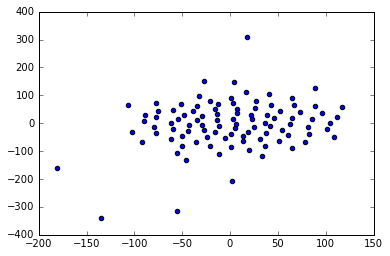

In [93]:
plt.scatter(ts[:,0], ts[:,1])

In [12]:
import itertools

In [ ]:
itertools.product